We have produced a measure fot the proprotion of MDIs as a prorpotion of all inhalers (excluding MDI and DPI). We excluded salbuatmol for two reasons a) it is particularly important that patients have the most effective form of inhaler for them and b) about 60% of salbutamol inhalers are prescribed generically, so we can’t tell from the prescribing data which manufacturer’s MDI, and therefore the GWP,  has been supplied supplied from the data. 

However as the [most commonly prescribed inhaler](https://openprescribing.net/analyse/#org=CCG&numIds=0301011R0&denom=nothing&selectedTab=summary) we would like to review prescribing of salbutamol here.

We propose a measure of _"The percentage of prescriptions for Salbutamol Inhlaers where the quantity is greater than 2"_

There are two aspects to this a) if someone is using large quantities of releiver inhalers it indicates that their asthma may not be controlled (although we cannot tell for each patient how many they are getting) b) whilst somebody may be obtaining the inhalers their asthma may be well controlled but their repeat prescription has not been altered. Here there is an oppurtnity to reduce (reduce, resuse, recycle eh?!)

In [1]:
##importing libraries
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
sql = '''
SELECT
  month,
  pct,
  SUM(CASE
      WHEN quantity_per_item>2 THEN total_quantity
    ELSE
    0
  END
    ) AS more_than_two,
  SUM(total_quantity) AS all_inhlaers,
  IEEE_DIVIDE(SUM(CASE
        WHEN quantity_per_item>2 THEN total_quantity
      ELSE
      0
    END
      ), SUM(total_quantity))*100 AS percent_more_than_two
FROM
  ebmdatalab.hscic.raw_prescribing_normalised AS presc
JOIN
  hscic.ccgs AS ccgs
ON
  presc.pct=ccgs.code
WHERE
  presc.bnf_code IN (
  SELECT
    DISTINCT(bnf_code)
  FROM
    measures.vw__chapter_3_dmd_objs_with_form_route ###this is a view with just inhalers
  WHERE
    form_route = 'pressurizedinhalation.inhalation' ) ##lets just look at MDI
  AND bnf_code LIKE "0301011R0%"
  AND ccgs.org_type='CCG'
GROUP BY
  month,
  pct
ORDER BY
  percent_more_than_two DESC
    '''

df_salb_qty = bq.cached_read(sql, csv_path='salb_qty.csv')
df_salb_qty['month'] = df_salb_qty['month'].astype('datetime64[ns]')
df_salb_qty.head()

,month,pct,more_than_two,all_inhlaers,percent_more_than_two
0,2018-08-01,07Y,870,6885,12.636166
1,2018-05-01,07Y,895,7707,11.612820
2,2018-07-01,07Y,886,7700,11.506494
3,2019-01-01,07Y,931,8159,11.410712
4,2017-12-01,07Y,1020,9255,11.021070


C:\Users\bmackenna\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


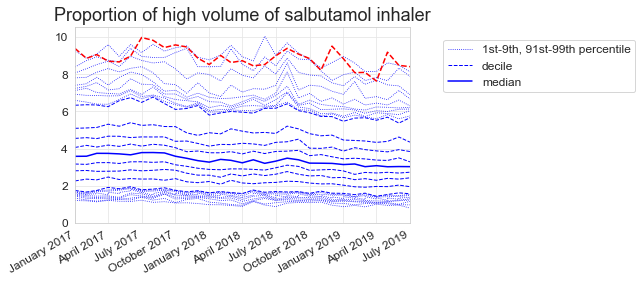

In [3]:
#create sample deciles

charts.deciles_chart(
        df_salb_qty,
        period_column='month',
        column='percent_more_than_two',
        title="Proportion of high volume of salbutamol inhaler",
        show_outer_percentiles=True)

#add in example CCG (Islington - 08H)
df_subject = df_salb_qty.loc[df_salb_qty['pct'] == '08H'].sort_values(by=['month'])
plt.plot(df_subject['month'], df_subject['percent_more_than_two'], 'r--')

plt.show()

In [4]:
latest_df_salb_qty = df_salb_qty.loc[(df_salb_qty['month'] == '2019-06-01')]

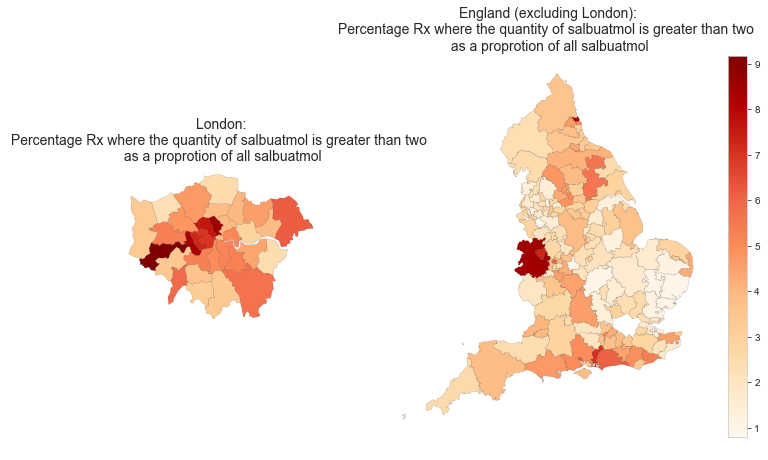

In [5]:
#create choropeth map 
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(latest_df_salb_qty, title=" Percentage Rx where the quantity of salbuatmol is greater than two  \n as a proprotion of all salbuatmol", column='percent_more_than_two', separate_london=True)
plt.show()